In [1]:
from osgeo import gdal, osr, ogr
import os
import shutil
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import copy
import math
import random

The 1st section below - setting the path to input files. Set "clipped_files_exist" to 1 if you want to use previously created clipped files for the classification.

There are recommendations in the HLS V2 Manual to complete cloud musking including:cirrus, cloud, adjacent cloud pixels. Add integer numbers to "i_filter" list if you want to filter the following:
1 - cirrus pixels(bit number 0 (to read binary in python it should have index [-1]);
2 - cloud pixels(bit number 1 [-2];
3 - adjacent cloud pixels (bit number 2 [-3]);
4 - cloud shadow pixels (bit number 3 [-4]);
5 - snow/ice pixels (bit number 4 [-5]);
6 - water pixels (bit number 5 [-6]).

In [2]:
script_path = os.getcwd() # use current directory
i_filter = [2] # see comment above. "Minus" sign added later
#script_path = os.path.join("U:","HLS_project","data")#'U:/HLS_project/data/' # to save files in folders different from the current directory (should contain the same folders as in the current directory)
#input_path = script_path # in case .hdf files are in the "/input/" folder relative to the current directory
input_path = os.path.join("/","media","oleks","Transcend","OSU",
                          "HLSv2_LA3_data","structured_HLS.v2.0.16RBT.2016.2022.LA3.Bands_RED_NIR_QA","16RBT","2018")# '/media/oleks/Transcend/OSU/OWC_DATA/2016/' # in case of using hdf files outside the current directory
QA_in_3band_tif = 0 # 1 - if clipped files are 3-band tif, 0 - if bands are in separate files
clip_feature = os.path.join(script_path,"shape","polygon_LA3_1000m_buffer_32616.shp") # path to the shape file used for clipping
path_Sentinel_data = os.path.join(input_path, "input", "S")
path_Landsat_data = os.path.join(input_path, "input", "L")
print("script_path: ", script_path)
print("input_path: ", input_path)
# !!! TO CREATE NEW  CLIPPED FILES SET QA_in_3band_tif = 0 

script_path:  /home/oleks/Documents/OSU-work/Louisiana/python-code/for_github/pt_clip_class_v6.3_LA3_HLS_v2
input_path:  /media/oleks/Transcend/OSU/HLSv2_LA3_data/structured_HLS.v2.0.16RBT.2016.2022.LA3.Bands_RED_NIR_QA/16RBT/2018


HLS v2 from LC DAAC (each band is separate).
This section opens .tif files and creates clipped .tif files of the area of interest. Make sure the "input_path" directory contains '/input/S/' and '/input/L/' folders with downloaded files. If only Landsat or Sentinal data is used, set "path_Sentinel_data" or "path_Landsat_data" some empty folder.

!!! For the HLS v2 files from LC DAAC use this section:

In [3]:
#make sure that script_path directory contains the next folders:
folders = [os.path.join(script_path, "output", "interim_files"),
          os.path.join(script_path, "output", "interim_files","vrt"),
          os.path.join(script_path, "output", "interim_files","bands"),
          os.path.join(script_path, "output", "QA_TIF"),
          os.path.join(script_path, "output","3BANDS_TIF")]
clf = os.path.join(script_path, "output", "QA_TIF") # folder for separate QA .tif files
#to make sure that previous files are copied to different folder:
answ = input("Do you want to delete all previous output files before the start? "\
            "Enter [y] - Yes; [n] - No. Any answer except [y] terminates execution") 
if answ == 'y': 
    for clf in folders:
        for filename in os.listdir(clf):
                if filename.endswith(".tif") or filename.endswith(".xml") or filename.endswith(".vrt"):
                    os.remove(os.path.join(clf, filename))
    print("Previous files have been deleted")
elif answ == 'n':  
    print("Execution terminated")
    quit()
else:
    print("Execution terminated")
    quit()
# opening bands (in separate .tif files)
files_to_open = []
clipped_bands = []
vrt_path = os.path.join(script_path, "output", "interim_files","vrt") # .vrt files are used to create 3-band .tif files
folder_paths = [path_Sentinel_data, path_Landsat_data]
output_folder = os.path.join(script_path, "output")
for folder_path in folder_paths:
    for filename in os.listdir(folder_path):
        if filename.endswith("Fmask.tif"): 
            fp = os.path.join(folder_path, filename)
            files_to_open.append(fp)
print(str(len(files_to_open)) + " files detected")
#opening files hdf files in a loop
f_count = 0
for f in files_to_open:
    image_date = f[-29: -22] # part of the filename containing year+day
    input_fname = f[-44: -10] # final output name of .tif file
    layer_bands = []
    red_band = input_fname + ".B04.tif"
    qa_band = input_fname + ".Fmask.tif"
    if "HLS.L30." in f: # if file is from the Landsat (L) dataset
        nir_band = input_fname + ".B05.tif"
        db = ".HLS.L30."
        folder_path = os.path.join(input_path, "input", "L") 
    if "HLS.S30." in f: # if file is from the Sentinel (S) dataset
        nir_band = input_fname + ".B8A.tif"
        db = ".HLS.S30."
        folder_path = os.path.join(input_path, "input", "S")
    bands = [red_band,nir_band,qa_band]
    in_vrt = [] 
    for b in bands:
        if "B05" in b or "8A" in b:
            suffix = "NIR"
        if "B04" in b:
            suffix = "RED"
        if "Fmask" in b:
            suffix = "_QA"
        layer_band = image_date + db + "band" + suffix # 
        layer_bands.append(layer_band)
        in_data = os.path.join(folder_path, b)
        sd = gdal.Open(in_data)
        arr = sd.ReadAsArray()
        [cols, rows] = arr.shape
        driver = gdal.GetDriverByName("GTiff")
        in_raster = os.path.join(script_path, "output", "interim_files", in_data + ".tif")
        if "Fmask" in b: 
            outdata = driver.Create('in_raster.tif', rows, cols, 1, gdal.GDT_Int16)
        else:
            outdata = driver.Create('in_raster.tif', rows, cols, 1, gdal.GDT_Float32) #gdal.GDT_UInt16
        outdata.SetGeoTransform(sd.GetGeoTransform())##sets same geotransform as input
        outdata.SetProjection(sd.GetProjection())##sets same projection as input
        outdata.GetRasterBand(1).WriteArray(arr)
        outdata.GetRasterBand(1).SetNoDataValue(-9999)## no data value should be -9999
        outdata.FlushCache() ##saves to disk
        outdata = None
        sd = None
        data = None
        
        out_raster = os.path.join(script_path, "output", "interim_files", "bands", layer_band +".tif")
        in_vrt.append(out_raster) # creating a list for the next step - building virtual 3-band raster 
        gdal.Warp(out_raster, 'in_raster.tif', cutlineDSName=clip_feature, cropToCutline=True)
        os.remove('in_raster.tif')

    # for building virtual 3-band raster:
    ImageList = [in_vrt[0], in_vrt[1], in_vrt[2]]
    VRT = os.path.join(vrt_path, image_date + ".vrt")

    # !!! osgeo.gdal fails to save bands in different formats

    gdal.BuildVRT(VRT, ImageList, separate=True, callback=gdal.TermProgress_nocb)
    InputImage = gdal.Open(VRT, 0)  # open the VRT in read-only mode
    
    output_name = image_date + "." + input_fname[-44: -20] + ".v2.0.tif" # final output name of .tif file
    TRANSL = os.path.join(script_path, "output", "3BANDS_TIF", output_name)
    gdal.Translate(TRANSL, InputImage, format='GTiff', creationOptions=['COMPRESS:DEFLATE', 'TILED:YES'],\
               callback=gdal.TermProgress_nocb)
    del InputImage  # close the VRT        
    f_count += 1
    print("completed: ", f_count, " of ", len(files_to_open), " files")
    ds = None
print("done")


Do you want to delete all previous output files before the start? Enter [y] - Yes; [n] - No. Any answer except [y] terminates executiony
Previous files have been deleted
89 files detected
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  1  of  89  files


Warning 1: 2018003.HLS.S30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  2  of  89  files


Warning 1: 2018008.HLS.S30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  3  of  89  files


Warning 1: 2018018.HLS.S30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  4  of  89  files


Warning 1: 2018033.HLS.S30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  5  of  89  files


Warning 1: 2018038.HLS.S30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  6  of  89  files


Warning 1: 2018048.HLS.S30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  7  of  89  files


Warning 1: 2018058.HLS.S30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  8  of  89  files


Warning 1: 2018063.HLS.S30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  9  of  89  files


Warning 1: 2018068.HLS.S30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  10  of  89  files


Warning 1: 2018028.HLS.S30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  11  of  89  files


Warning 1: 2018053.HLS.S30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  12  of  89  files


Warning 1: 2018073.HLS.S30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  13  of  89  files


Warning 1: 2018093.HLS.S30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  14  of  89  files


Warning 1: 2018118.HLS.S30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  15  of  89  files


Warning 1: 2018138.HLS.S30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  16  of  89  files


Warning 1: 2018158.HLS.S30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  17  of  89  files


Warning 1: 2018188.HLS.S30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  18  of  89  files


Warning 1: 2018218.HLS.S30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  19  of  89  files


Warning 1: 2018248.HLS.S30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  20  of  89  files


Warning 1: 2018268.HLS.S30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  21  of  89  files


Warning 1: 2018293.HLS.S30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  22  of  89  files


Warning 1: 2018083.HLS.S30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  23  of  89  files


Warning 1: 2018088.HLS.S30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  24  of  89  files


Warning 1: 2018108.HLS.S30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  25  of  89  files


Warning 1: 2018113.HLS.S30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  26  of  89  files


Warning 1: 2018123.HLS.S30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  27  of  89  files


Warning 1: 2018128.HLS.S30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  28  of  89  files


Warning 1: 2018133.HLS.S30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  29  of  89  files


Warning 1: 2018143.HLS.S30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  30  of  89  files


Warning 1: 2018148.HLS.S30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  31  of  89  files


Warning 1: 2018153.HLS.S30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  32  of  89  files


Warning 1: 2018163.HLS.S30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  33  of  89  files


Warning 1: 2018173.HLS.S30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  34  of  89  files


Warning 1: 2018178.HLS.S30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  35  of  89  files


Warning 1: 2018203.HLS.S30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  36  of  89  files


Warning 1: 2018208.HLS.S30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  37  of  89  files


Warning 1: 2018213.HLS.S30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  38  of  89  files


Warning 1: 2018228.HLS.S30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  39  of  89  files


Warning 1: 2018233.HLS.S30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  40  of  89  files


Warning 1: 2018243.HLS.S30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  41  of  89  files


Warning 1: 2018253.HLS.S30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  42  of  89  files


Warning 1: 2018258.HLS.S30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  43  of  89  files


Warning 1: 2018273.HLS.S30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  44  of  89  files


Warning 1: 2018278.HLS.S30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  45  of  89  files


Warning 1: 2018283.HLS.S30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  46  of  89  files


Warning 1: 2018303.HLS.S30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  47  of  89  files


Warning 1: 2018308.HLS.S30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  48  of  89  files


Warning 1: 2018323.HLS.S30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  49  of  89  files


Warning 1: 2018338.HLS.S30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  50  of  89  files


Warning 1: 2018348.HLS.S30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  51  of  89  files


Warning 1: 2018358.HLS.S30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  52  of  89  files


Warning 1: 2018007.HLS.L30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  53  of  89  files


Warning 1: 2018014.HLS.L30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  54  of  89  files


Warning 1: 2018023.HLS.L30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  55  of  89  files


Warning 1: 2018039.HLS.L30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  56  of  89  files


Warning 1: 2018046.HLS.L30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  57  of  89  files


Warning 1: 2018055.HLS.L30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  58  of  89  files


Warning 1: 2018071.HLS.L30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  59  of  89  files


Warning 1: 2018078.HLS.L30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  60  of  89  files


Warning 1: 2018087.HLS.L30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  61  of  89  files


Warning 1: 2018030.HLS.L30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  62  of  89  files


Warning 1: 2018062.HLS.L30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  63  of  89  files


Warning 1: 2018094.HLS.L30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  64  of  89  files


Warning 1: 2018126.HLS.L30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  65  of  89  files


Warning 1: 2018206.HLS.L30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  66  of  89  files


Warning 1: 2018238.HLS.L30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  67  of  89  files


Warning 1: 2018270.HLS.L30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  68  of  89  files


Warning 1: 2018103.HLS.L30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  69  of  89  files


Warning 1: 2018110.HLS.L30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  70  of  89  files


Warning 1: 2018119.HLS.L30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  71  of  89  files


Warning 1: 2018135.HLS.L30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  72  of  89  files


Warning 1: 2018142.HLS.L30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  73  of  89  files


Warning 1: 2018151.HLS.L30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  74  of  89  files


Warning 1: 2018167.HLS.L30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  75  of  89  files


Warning 1: 2018174.HLS.L30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  76  of  89  files


Warning 1: 2018190.HLS.L30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  77  of  89  files


Warning 1: 2018215.HLS.L30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  78  of  89  files


Warning 1: 2018222.HLS.L30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  79  of  89  files


Warning 1: 2018231.HLS.L30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  80  of  89  files


Warning 1: 2018247.HLS.L30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  81  of  89  files


Warning 1: 2018254.HLS.L30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  82  of  89  files


Warning 1: 2018263.HLS.L30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  83  of  89  files


Warning 1: 2018279.HLS.L30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  84  of  89  files


Warning 1: 2018286.HLS.L30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  85  of  89  files


Warning 1: 2018295.HLS.L30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  86  of  89  files


Warning 1: 2018302.HLS.L30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  87  of  89  files


Warning 1: 2018311.HLS.L30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  88  of  89  files


Warning 1: 2018334.HLS.L30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0completed:  89  of  89  files
done


Warning 1: 2018359.HLS.L30.T16RBT.v2.0.tif: Unable to export GeoTIFF file with different datatypes per different bands. All bands should have the same types in TIFF.


This section helps to find some info about files: width, height and number of pixels belonging to the wetland. Check clipped files, find one that is not spoiled. Run the code and enter the year (4 digits) and doy of this file (3-digit, day of the year) without using space key

In [4]:
# delete temporary files:

folders = [os.path.join(script_path, "output", "interim_files","vrt"),
          os.path.join(script_path, "output", "interim_files","bands"),
          os.path.join(script_path, "output", "interim_files")]
for clf in folders:
    for filename in os.listdir(clf):
            if filename.endswith(".tif") or filename.endswith(".xml") or filename.endswith(".vrt") \
                                                                        or filename.endswith(".hdr"):
                if "QA.tif" in filename:
                    shutil.copy2(os.path.join(clf,filename), os.path.join(script_path, "output", "QA_TIF", filename))
                                                        # copy all QA tif in one folder QA_TIF
                os.remove(os.path.join(clf,filename))    
year_doy = input("Find one file that contains high quality data (check the size of the file). Enter year and doy. Example: 2021001 ")


if QA_in_3band_tif == 0:
    path_clipped_files = os.path.join(script_path, "output", "QA_TIF")
    try:
        src = rasterio.open(os.path.join(path_clipped_files, year_doy + ".HLS.L30.band_QA.tif"), "r")
        suf_ds = ".L30."
    except:
        src = rasterio.open(os.path.join(path_clipped_files, year_doy + ".HLS.S30.band_QA.tif"), "r")
        suf_ds = ".S30."
else:
    path_clipped_files = os.path.join(script_path, "output", "3BANDS_TIF")
    try:
        src = rasterio.open(os.path.join(path_clipped_files, year_doy + '.HLS.L30.T16RBT.v2.0.tif'), "r")
    except:
        src = rasterio.open(os.path.join(path_clipped_files, year_doy + '.HLS.S30.T16RBT.v2.0.tif'), "r")
raster_width=src.width
raster_height=src.height
print("File dimension is: ", raster_height, "x", raster_width, "(height x width) ")
band1 = src.read(1)
clipped_area = (band1 > 0).sum()
print("clipped area in pixels: ", clipped_area)
tif_boundaries = src.bounds
left_bound = tif_boundaries[0]
bottom_bound = tif_boundaries[1]
right_bound = tif_boundaries[2]
top_bound = tif_boundaries[3]
crs_used = src.crs
print(tif_boundaries)

Find one file that contains high quality data (check the size of the file). Enter year and doy. Example: 2021001 2018003
File dimension is:  65 x 66 (height x width) 
clipped area in pixels:  4290
BoundingBox(left=216360.0, bottom=3265260.0, right=218340.0, top=3267210.0)


These codes calculate and build NDVI time series of each pixel using HLS (Harmonized Landsat and Sentinel-2) dataset near the US-LA3 flus tower. The NDVI time series are then used to classify landcovers. The whole year data of HLS was clipped to the 2-km side extent, and tree bands (red, near infrared and QA) were extracted. In 2018, there were three main land-cover types: 1) open water, 2) Spatina, 3) Juncus.
Calculalte ndvi and filter clouds. The data used here only has three bands extracted from the original HLS data. Band 1 is red, band 2 is NIR and band 3 is QA band.
*Amended version. If variable "three_band_tif" is set to 0, then bands from separate files are used (recommended for new files)

In [7]:
ndvi = []
fname = []
directory = os.path.join(script_path, "output", "3BANDS_TIF") # the path to the clipped files 
directory_QA = os.path.join(script_path, "output", "QA_TIF") # the path to the QA band
cloud_temp = np.empty([raster_height,raster_width], dtype = int) # dimension is taken from 'clipping' part of the code
cloud_code = []
nan = np.nan
NaN = np.nan
for filename in os.listdir(directory):
    if filename.endswith(".tif"):
        fp = os.path.join(directory, filename)
        year_doy = fp[-31:-25]
        suf_ds = fp[-25:-15]
        qafilename = year_doy + suf_ds + "band_QA.tif"
        qafp = os.path.join(directory_QA, qafilename)
        raster_temp = rasterio.open(fp)
        red_temp = raster_temp.read(1) 
        nir_temp = raster_temp.read(2) #scale factor = 0.0001 for both near and red (in L and S)
        qa_temp = rasterio.open(qafp) 
        QA = qa_temp.read(1)  
        if np.all(QA == -9999):
            continue
        else:  
            for m in range (0,raster_height): 
                for n in range (0,raster_width):
                    if QA[m][n] == -9999:
                        cloud_temp[m][n] = -9999
                    else:
                        cloud_temp[m][n] = int(("{0:08b}".format(QA[m][n]))[-2])
            cloud_copy = copy.copy(cloud_temp)          
            cloud_code.append(cloud_copy)
            cloud_index = np.argwhere(cloud_copy == 1)
            ndvi_temp = np.empty(QA.shape, dtype=rasterio.float32)    
            check = np.logical_and(red_temp > 0, nir_temp > 0)
            ndvi_temp = np.where(check,(nir_temp - red_temp ) / ( nir_temp + red_temp ),np.nan)
            ndvi_temp[cloud_index[:,0],cloud_index[:,1]] = np.nan
            ndvi.append(ndvi_temp)
            name_temp = filename[4:7]
            name_copy = copy.copy(name_temp)
            fname.append(name_copy)
    else:
        continue
#get day of year
ndvi_doy = []
for fname in fname:
    ndvi_doy.append(int(fname))
print("ndvi_doy: ", ndvi_doy)

/tmp/ipykernel_5488/1351593247.py:35: RuntimeWarning: divide by zero encountered in true_divide
  ndvi_temp = np.where(check,(nir_temp - red_temp ) / ( nir_temp + red_temp ),np.nan)


ndvi_doy:  [311, 358, 83, 338, 203, 295, 303, 28, 273, 110, 94, 163, 302, 308, 279, 53, 48, 118, 33, 62, 68, 138, 359, 334, 78, 63, 93, 88, 133, 58, 258, 73, 215, 270, 71, 87, 278, 30, 178, 253, 248, 128, 38, 238, 113, 46, 39, 206, 173, 323, 233, 222, 293, 123, 218, 135, 55, 148, 190, 283, 151, 247, 243, 119, 108, 14, 143, 254, 23, 286, 142, 228, 153, 3, 103, 167, 268, 174, 126, 213, 8, 263, 348, 188, 231, 208, 158, 18, 7]


Keep only growing season (the whole year for LA3) NDVI images for classification + sorting doy

In [8]:
gs_first_date = 0
gs_last_date = 367

# set nan if there is no need to add first_dgs or last_dgs 
first_dgs = nan # type doy (if there is not spoiled image close to the first day of growing season)
last_dgs = nan # type doy (add doy close to the last day of growing season if needed)
ndays = len(ndvi_doy)
nrows = raster_height 
ncols = raster_width 
pixels_N = raster_height * raster_width 
ndvi_pixel = np.empty([pixels_N,ndays]) 
for m in range (0,nrows):
    for n in range (0,ncols):        
        for i in range(0,ndays):
            pixel_row = m*raster_width+n
            ndvi_pixel[pixel_row][i] = ndvi[i][m][n]
ndvi_pixel1=np.vstack((np.array(ndvi_doy),np.array(ndvi_pixel)))
ndvi_pixel2=sorted(np.transpose(ndvi_pixel1),key=lambda x:x[0])
ndvi_pixel3=[]
n_pixels_wi_nan=len(ndvi_pixel2)
grow_s_doy = []
for i in range(0,n_pixels_wi_nan):
    if ndvi_pixel2[i][0]> gs_first_date and ndvi_pixel2[i][0]< gs_last_date:
        ndvi_pixel3.append(ndvi_pixel2[i][:])
        grow_s_doy.append(int(ndvi_pixel2[i][0]))
ndvi_sorted=np.transpose(np.array(ndvi_pixel3))[1::]
ndvi_doy_sorted=np.transpose(np.array(ndvi_pixel3))[0:1]

# exclude nans and put each image as a column, each row is ndvi time series of one pixel            
nan_index = []
ndvi_index = []
ndays_growing=np.size(ndvi_doy_sorted,1)
ndvi_owc = np.empty([clipped_area,ndays_growing])
count = 0
for i in range (1, pixels_N):
    if np.all(np.isnan(ndvi_sorted[i][:])):
        nan_index.append(i)
    else:
        ndvi_owc[count] = ndvi_sorted[i][:]
        ndvi_index.append(i)
        count = count+1
        continue
print("growing season doy selected: ", grow_s_doy)
if np.isnan(first_dgs) == False:
    grow_s_doy.insert(0,first_dgs)
if np.isnan(last_dgs) == False:
    grow_s_doy.append(last_dgs)
#print("growing season doy selected (with additional doy(s)): ", grow_s_doy)

growing season doy selected:  [3, 7, 8, 14, 18, 23, 28, 30, 33, 38, 39, 46, 48, 53, 55, 58, 62, 63, 68, 71, 73, 78, 83, 87, 88, 93, 94, 103, 108, 110, 113, 118, 119, 123, 126, 128, 133, 135, 138, 142, 143, 148, 151, 153, 158, 163, 167, 173, 174, 178, 188, 190, 203, 206, 208, 213, 215, 218, 222, 228, 231, 233, 238, 243, 247, 248, 253, 254, 258, 263, 268, 270, 273, 278, 279, 283, 286, 293, 295, 302, 303, 308, 311, 323, 334, 338, 348, 358, 359]


Plot all the ndvi images for groving season only

/tmp/ipykernel_5488/1922618199.py:2: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdYlGn").copy()
  my_cmap.set_under('w')


spoiled:  311


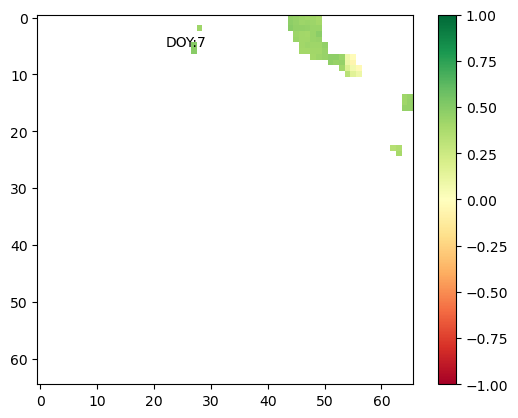

<Figure size 640x480 with 0 Axes>

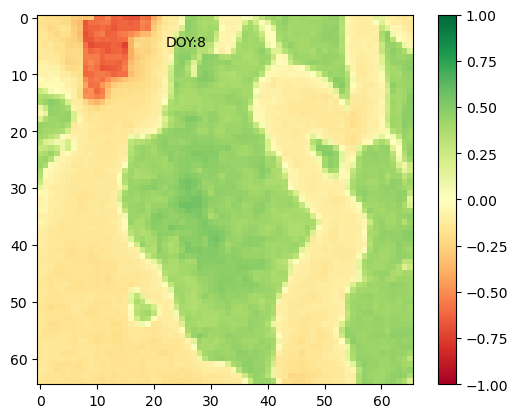

<Figure size 640x480 with 0 Axes>

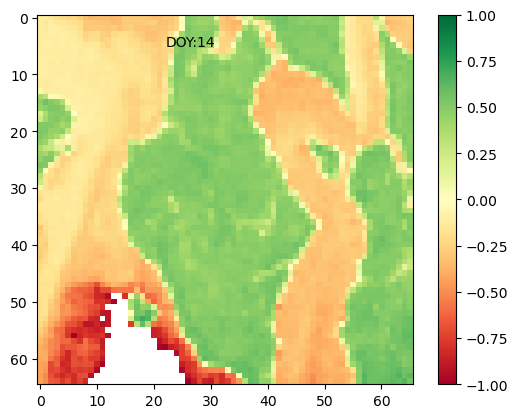

<Figure size 640x480 with 0 Axes>

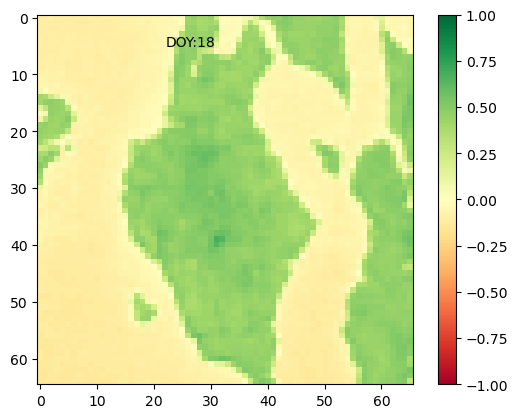

spoiled:  295


<Figure size 640x480 with 0 Axes>

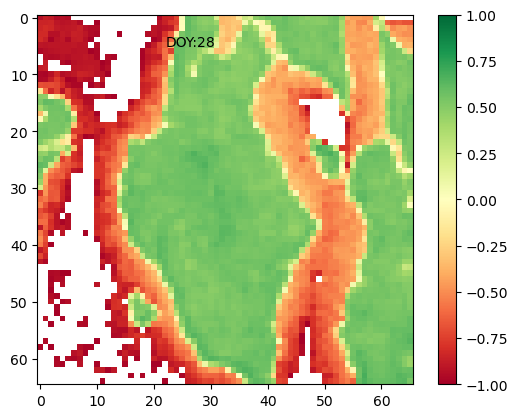

spoiled:  28
spoiled:  273
spoiled:  110
spoiled:  94


<Figure size 640x480 with 0 Axes>

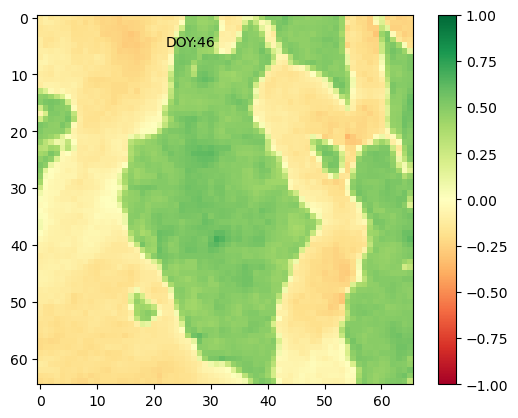

<Figure size 640x480 with 0 Axes>

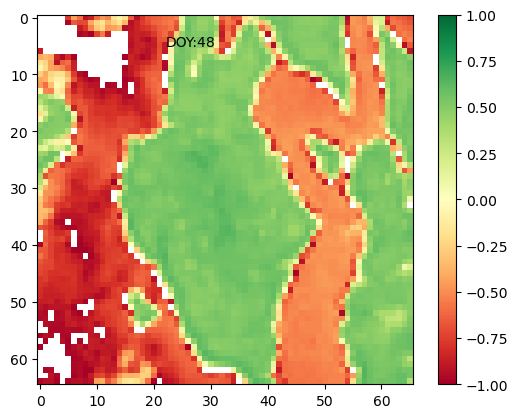

spoiled:  308
spoiled:  279


<Figure size 640x480 with 0 Axes>

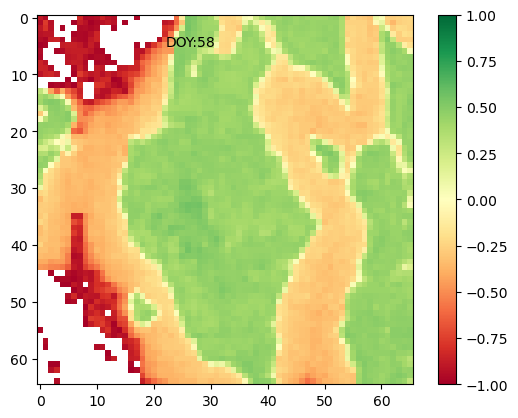

<Figure size 640x480 with 0 Axes>

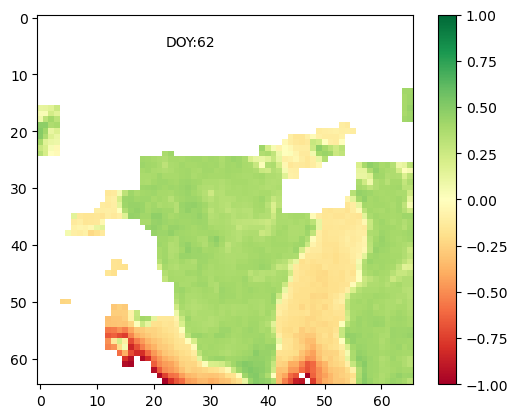

<Figure size 640x480 with 0 Axes>

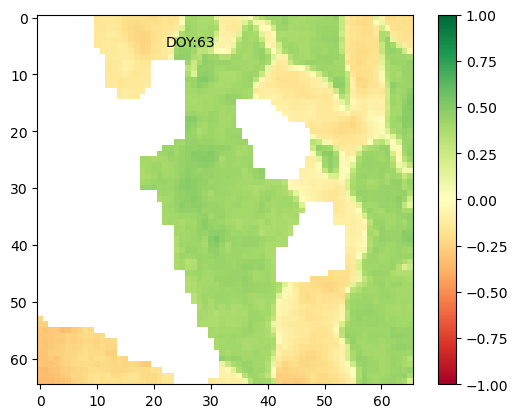

spoiled:  33


<Figure size 640x480 with 0 Axes>

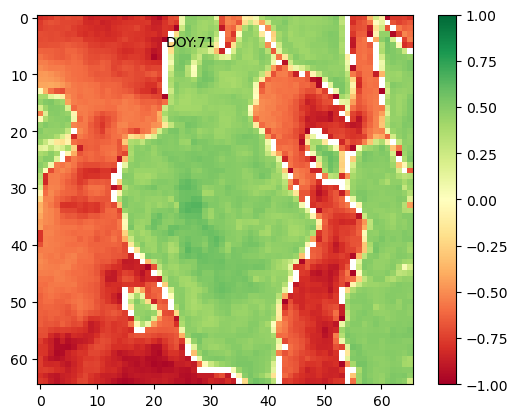

<Figure size 640x480 with 0 Axes>

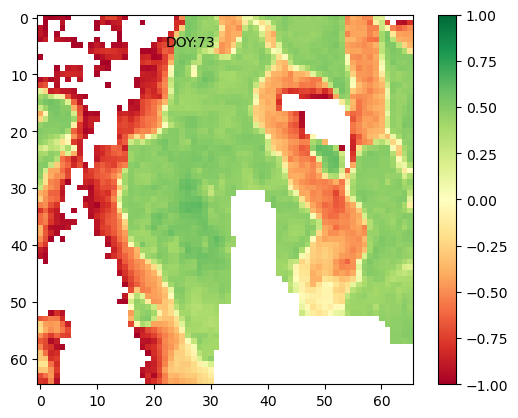

<Figure size 640x480 with 0 Axes>

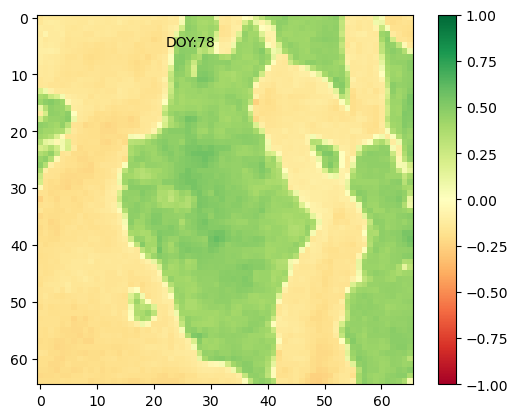

spoiled:  359
spoiled:  334
spoiled:  78


<Figure size 640x480 with 0 Axes>

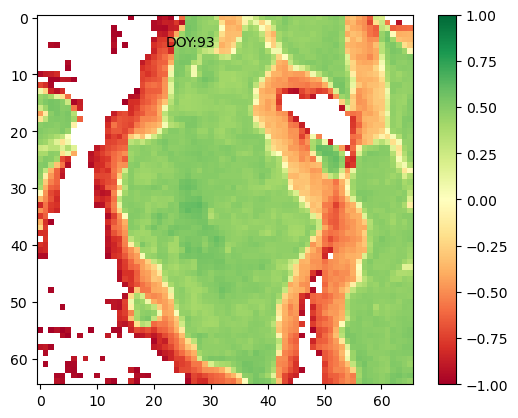

<Figure size 640x480 with 0 Axes>

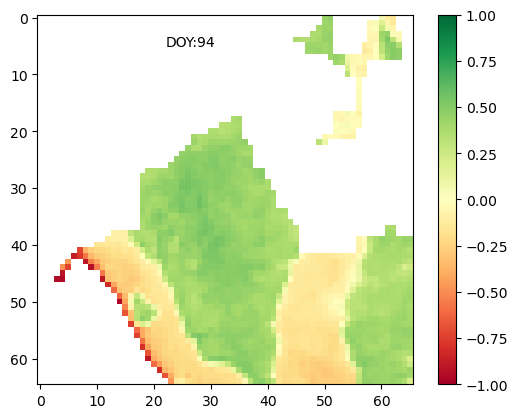

spoiled:  88


<Figure size 640x480 with 0 Axes>

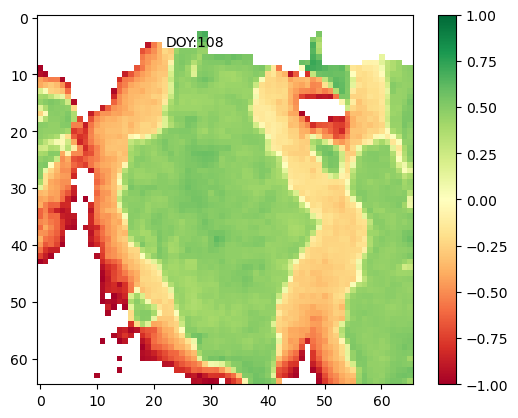

spoiled:  58


<Figure size 640x480 with 0 Axes>

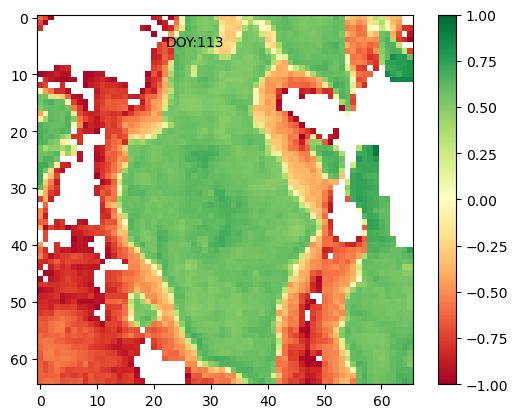

<Figure size 640x480 with 0 Axes>

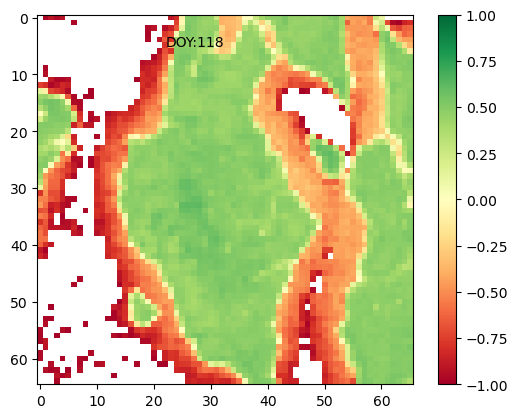

spoiled:  215
spoiled:  270
spoiled:  71
spoiled:  87


<Figure size 640x480 with 0 Axes>

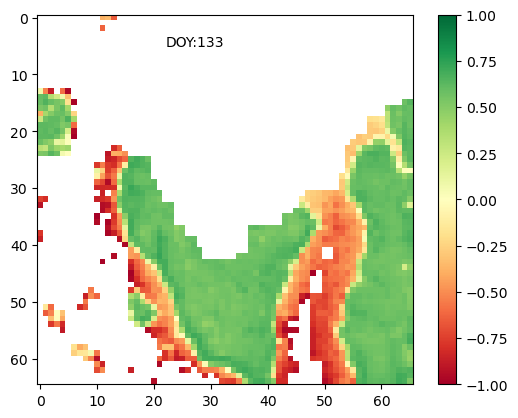

<Figure size 640x480 with 0 Axes>

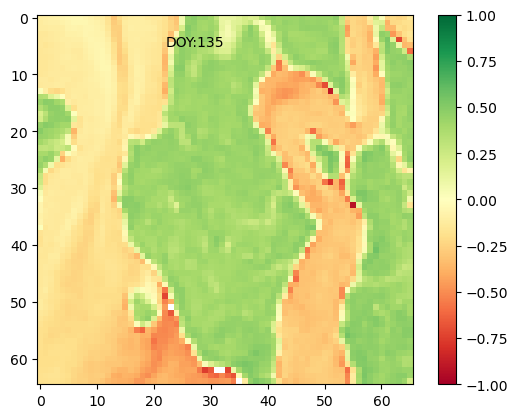

<Figure size 640x480 with 0 Axes>

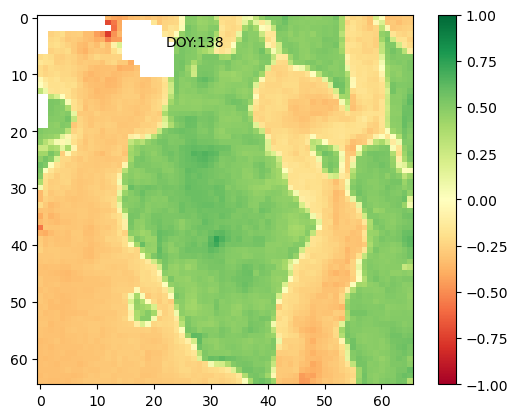

<Figure size 640x480 with 0 Axes>

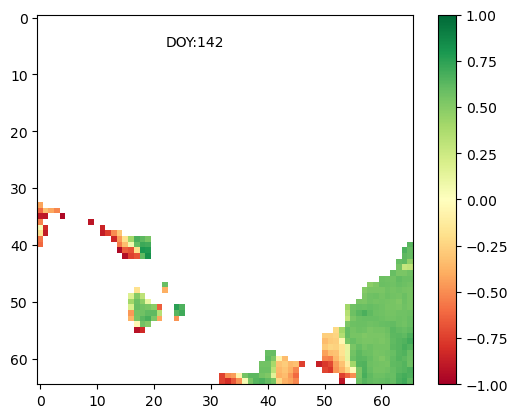

<Figure size 640x480 with 0 Axes>

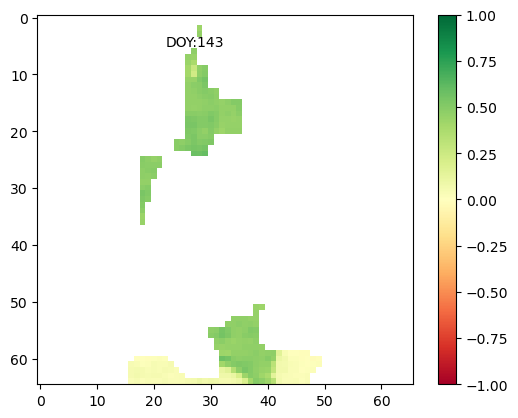

<Figure size 640x480 with 0 Axes>

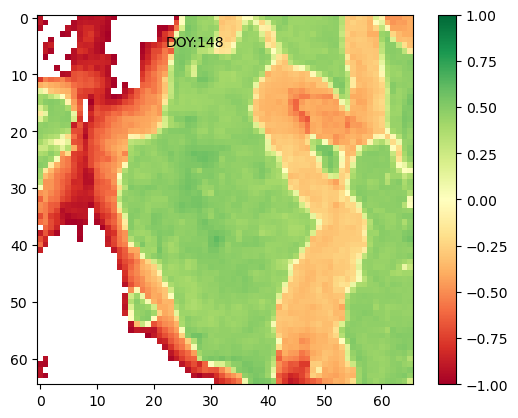

spoiled:  38


<Figure size 640x480 with 0 Axes>

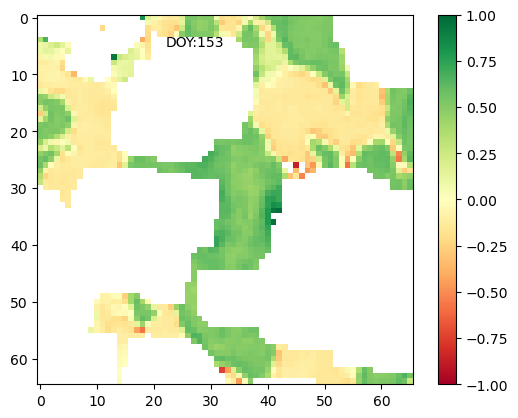

<Figure size 640x480 with 0 Axes>

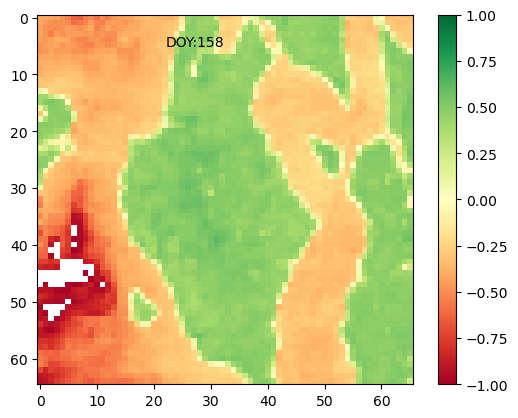

<Figure size 640x480 with 0 Axes>

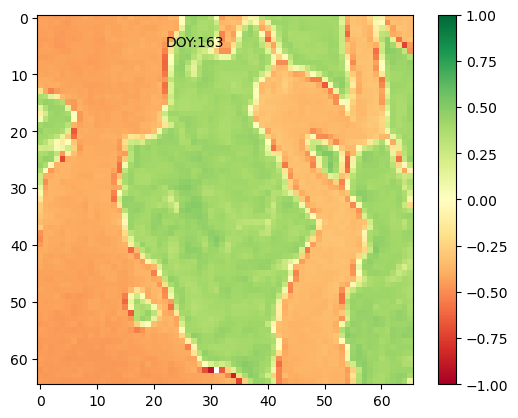

spoiled:  39


<Figure size 640x480 with 0 Axes>

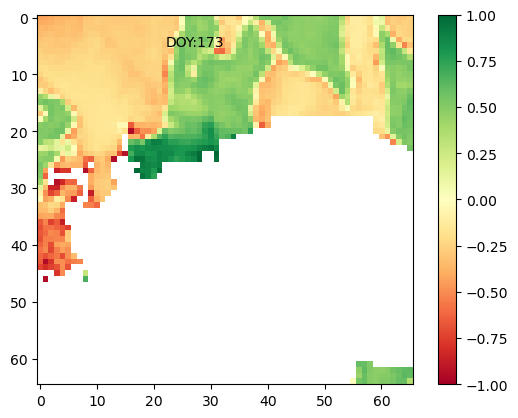

<Figure size 640x480 with 0 Axes>

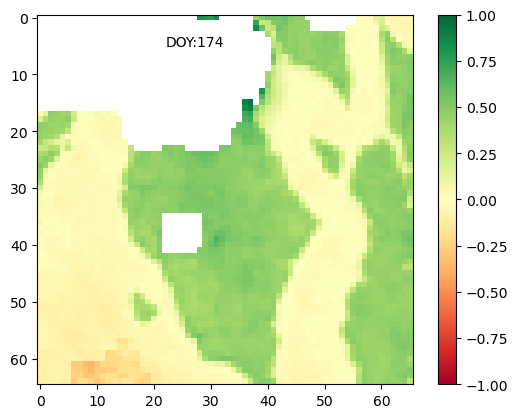

spoiled:  323


<Figure size 640x480 with 0 Axes>

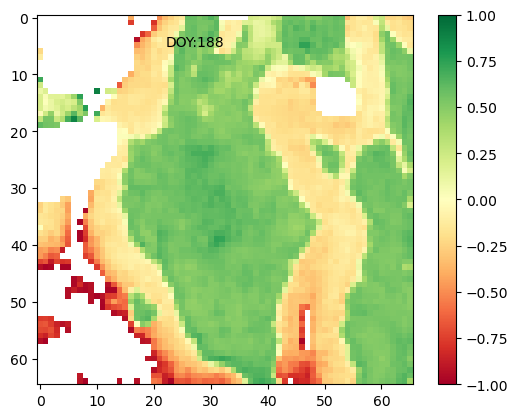

spoiled:  222


<Figure size 640x480 with 0 Axes>

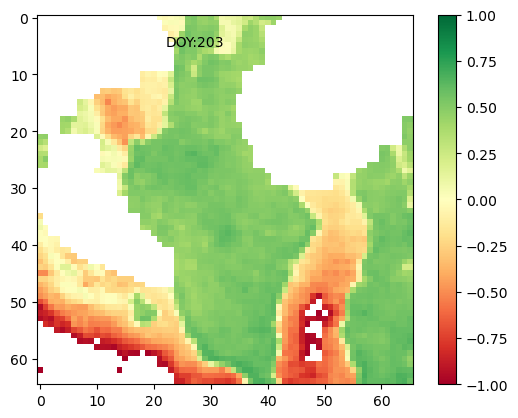

<Figure size 640x480 with 0 Axes>

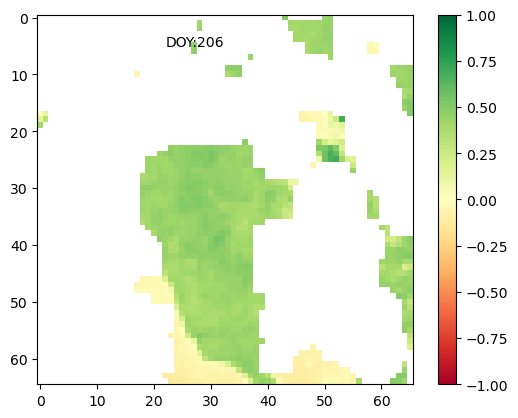

spoiled:  218
spoiled:  135
spoiled:  55


<Figure size 640x480 with 0 Axes>

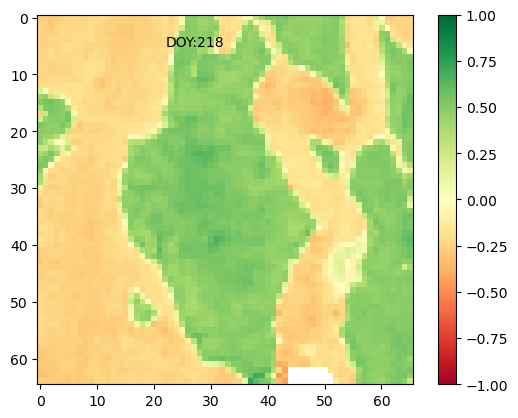

<Figure size 640x480 with 0 Axes>

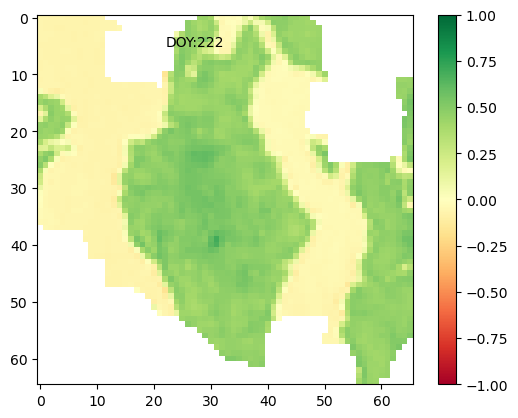

<Figure size 640x480 with 0 Axes>

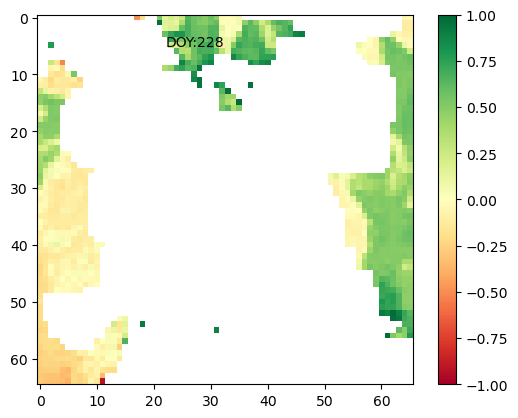

spoiled:  151
spoiled:  247


<Figure size 640x480 with 0 Axes>

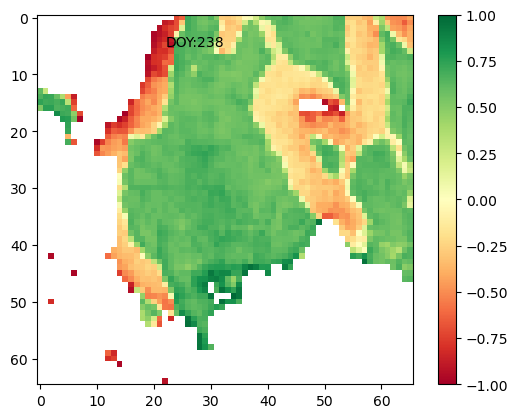

spoiled:  119


<Figure size 640x480 with 0 Axes>

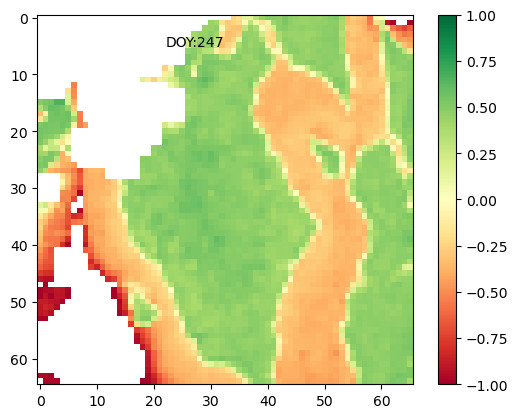

<Figure size 640x480 with 0 Axes>

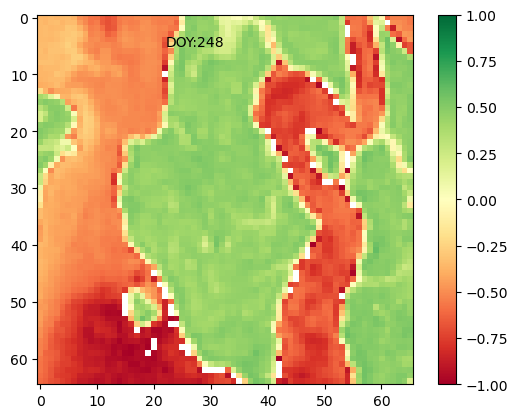

spoiled:  143


<Figure size 640x480 with 0 Axes>

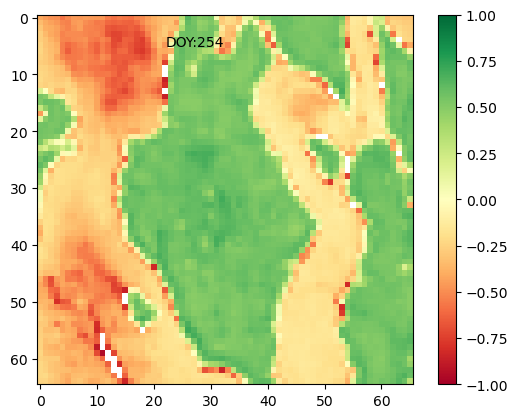

spoiled:  23


<Figure size 640x480 with 0 Axes>

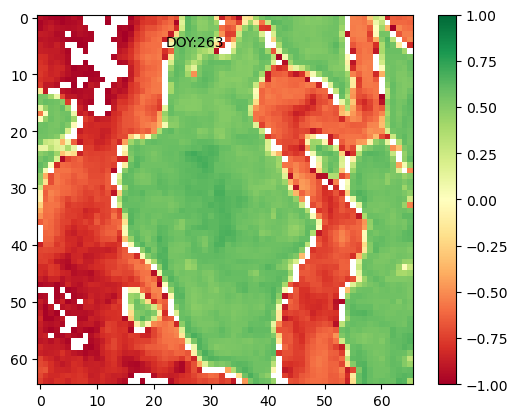

<Figure size 640x480 with 0 Axes>

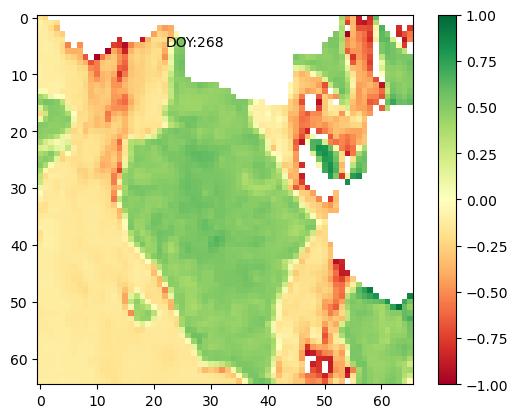

spoiled:  228


<Figure size 640x480 with 0 Axes>

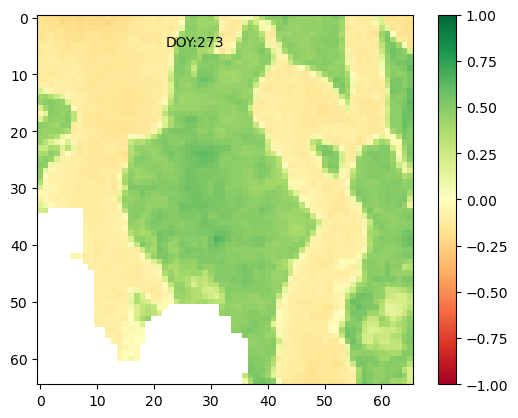

<Figure size 640x480 with 0 Axes>

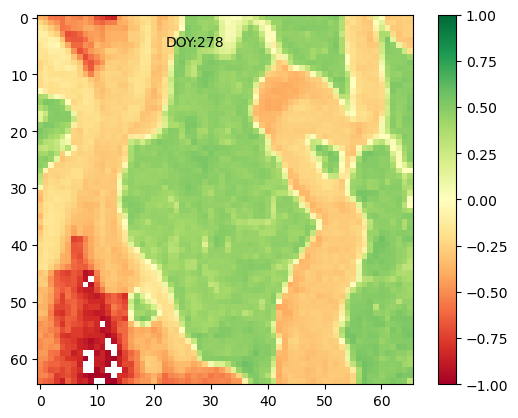

spoiled:  103
spoiled:  167


<Figure size 640x480 with 0 Axes>

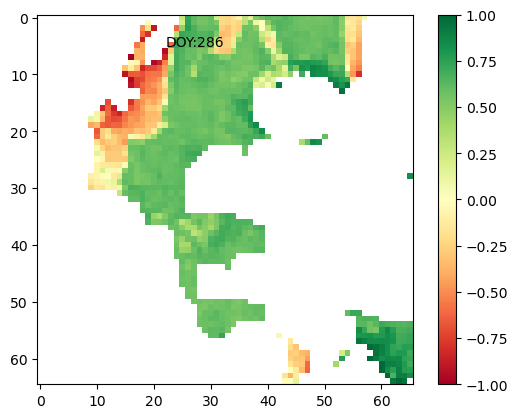

<Figure size 640x480 with 0 Axes>

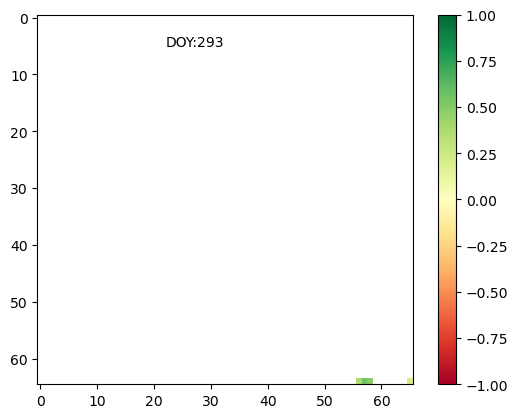

<Figure size 640x480 with 0 Axes>

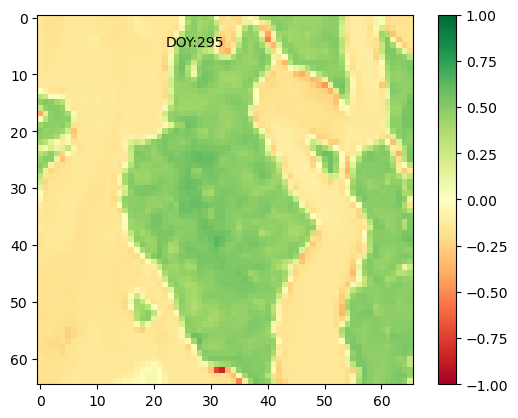

spoiled:  213
spoiled:  8
spoiled:  263


<Figure size 640x480 with 0 Axes>

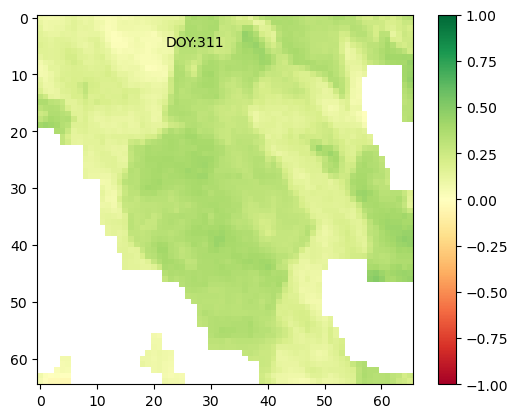

spoiled:  188
spoiled:  231


<Figure size 640x480 with 0 Axes>

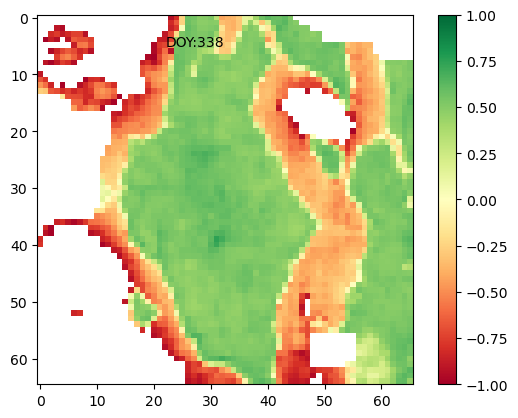

<Figure size 640x480 with 0 Axes>

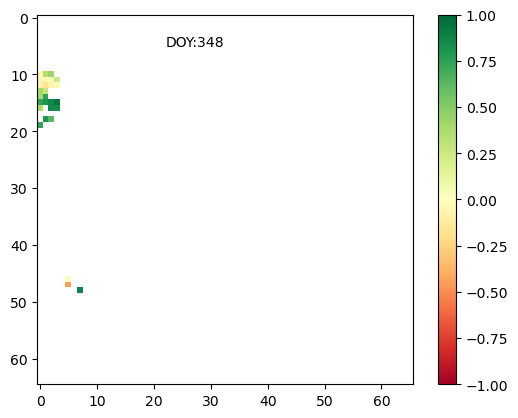

<Figure size 640x480 with 0 Axes>

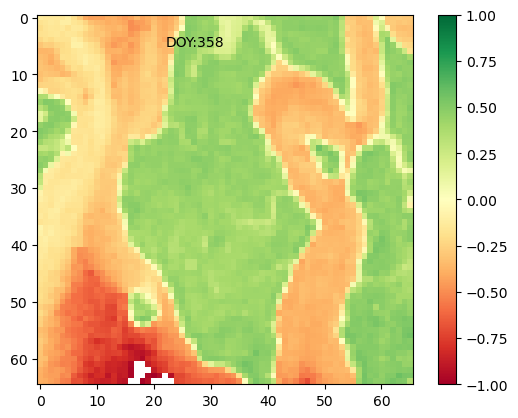

spoiled:  7
done


<Figure size 640x480 with 0 Axes>

In [9]:
my_cmap = matplotlib.cm.get_cmap('RdYlGn')
my_cmap.set_under('w')
fig = plt.figure()
dict_i_doy = {}
ind = np.arange(0, len(ndvi_doy), 1).tolist()
sorted_ndvi_doy = sorted(ndvi_doy)
for i in range (0, len(ind)):
    dict_i_doy[ind[i]] = sorted_ndvi_doy [i]
dict_grow_s_doy ={}
for i in range (0,len(grow_s_doy)):
    for j in range (0, len(ind)):
        if dict_i_doy[ind[j]] == grow_s_doy[i]:
            dict_grow_s_doy[grow_s_doy[i]] = ind[j]
for i in range (0, len(ind)):
    if np.all(np.isnan(ndvi[i])):
        print("spoiled: ", ndvi_doy[i])
        continue
    else:
        if dict_i_doy[i] > 0 and dict_i_doy[i] < 367:
            plt.figure(i)
            plt.imshow(ndvi[i], my_cmap, vmin = -1, vmax = 1)
            plt.colorbar()
            plt.text(22,5,'DOY:' + str(dict_i_doy[i]), fontsize=10)
            plt.show()
            plt.clf()
            #plt.savefig(str(i))
        else:
            continue
print("done")

The section below provides custom removal of spoiled DOY's. If there is no need to exclude some days, just run it with empty list excl_doy_list = [ ] 
Otherwise, in order to exclude spoiled data, add appropriate doy to the list: for example, excl_doy_list = [131, 145, 160]

In [9]:
excl_doy_list = []
excl_ind_list = []
dict_grow_s_doy = {}
dict_updated_grow_s_doy = {}
j=0
for i in range(0, len(grow_s_doy)):
    dict_grow_s_doy[grow_s_doy[i]] = i
for i in range(0, len(grow_s_doy)):
    if grow_s_doy[i] in excl_doy_list:
        excl_ind_list.append(dict_grow_s_doy[grow_s_doy[i]])
    else:
        dict_updated_grow_s_doy[j] = grow_s_doy[i]
        j+=1
ndvi_owc_update = ndvi_owc
ndvi_owc_update = np.delete(ndvi_owc_update,excl_ind_list,1)
print("spoiled and suspicious doy data have been excluded")

spoiled and suspicious doy data have been excluded


Interpolate each pixel's NDVI time series using linear interpolation

In [10]:
n_pixels=len(ndvi_owc_update)
#ndvi_owc_update = ndvi_owc
ndays_growing = (ndvi_owc_update.shape)[1] # in case of deleted days
file_index = []
#interpolation
ndvi_interp = np.empty([n_pixels,ndays_growing])
for i in range(0,n_pixels):
    ndvi_temp = pd.DataFrame(ndvi_owc_update[i,:])
    ndvi_interp_temp = ndvi_temp.interpolate(method='linear', limit_direction='both', axis=0)
    ndvi_interp[i,:] = np.transpose(ndvi_interp_temp)


drawing random time series to assess presence of outliers

In [ ]:
x = list(dict_updated_grow_s_doy.values())
print(x)
for part in range(0,5):
    fig, ax = plt.subplots(figsize=(13, 5))
    for sts in range(0,400):
        y = list(ndvi_interp[part*500 + sts])
        ax.scatter(x, y, marker = '.',color = 'black')
        ax.plot(x, y)
    plt.xlabel('doy')
    plt.ylabel('ndvi index')
    major_tick, minor_tick = [], []
    for mjt in range (0,360,30): major_tick.append(mjt)
    for mnt in range (0,360,10): major_tick.append(mnt)
    ax.set_xticks(major_tick) # Set major Grid
    ax.set_xticks(minor_tick, minor=True)# Set minor Grid
    ax.grid(True)
    plt.show()
    
print("time series for", part*400 + sts, " pixels have been pictured")

!!!
Skip the part below in case of calculating another year except the base year used for obtaining standard series. This part of codes creates shape file containing grid numbers of the area of interest (to overlay upon the Worldveiw data)

In [229]:
print("!!!! the next section rewrites standard series!!!")

!!!! the next section rewrites standard series!!!


In [230]:
from fiona import collection
from shapely.geometry import Point, mapping
import csv
input_crs = crs_used 
output_crs = crs_used #rasterio.crs.CRS.from_epsg(32616)
current_row = top_bound  
current_col = left_bound
shape_file_path = os.path.join(script_path, "output", "grid_index.csv")
header = ["Longitude", "Latitude", "Grid_number"]
data = []
grid_number = 0
for r in range (0,raster_height):
    for c in range (0, raster_width):
        grid_number = r*raster_width + c
        current_col += 30
        row = [str(current_col), str(current_row), str(grid_number)]
        
        data.append(row)
    current_row -= 30
    current_col = left_bound
with open(shape_file_path, 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    writer.writerows(data)
from csv import DictReader
import fiona
from fiona.crs import from_epsg
shape_file_path_new = os.path.join(script_path, "output", "grid_index.shp")
# Open a collection for writing.
with fiona.open(
        shape_file_path_new, 'w', 
        crs=crs_used, 
        driver='ESRI Shapefile', 
        schema={
            'geometry': 'Point', 
            'properties': {
                'Grid_number': 'float',
                'Longitude': 'float',
                'Latitude': 'float', 
                }}
        ) as output:
    
    # Make a mapping of property names to their Python types. This is used to
    # convert text values from the input to proper Python values.
    ptypes = {k: fiona.prop_type(v) for k, v in output.schema['properties'].items()}
    
    def feature(row):
        """Converts a table row and its index to a Fiona feature dict."""
        geom = {
            'type': 'Point', 
            'coordinates': [float(row['Longitude']), float(row['Latitude'])] }
        props = {k: ptypes[k](v) for k, v in row.items()}
        return {
            'type': 'Feature',
            'geometry': geom, 
            'properties': props }
    
    # Read rows and write all feature records in one go, using the feature()
    # function defined above.
    reader = DictReader(open(shape_file_path), delimiter=',')
    output.writerecords(map(feature, reader))

!!!Skip the part below in case of calculating another year except the basе year used for obtaining standard series. This part contains procedure of obtaining grid points numbers from csv file for time series avereging (in order to get standard time series for each patch type)

In [ ]:
# input manually information regarding visually classified grids to the file '/input/worldview_points.csv'
csv_pt = script_path + '/input/worldview_points.csv'
nan = np.nan
df = pd.read_csv(csv_pt)
csv_ptl = df['patch_type']
pt_row = df['lat_point']
pt_col = df['lon_point']
pt_point_number = df['point_number']
patch_types_list = []
colors = ["b","r","y","g"] # "r", "b", "o"  ->  add colors in case more patch types revealed
for patch in csv_ptl: # gather unique names of patch types
    if patch in patch_types_list:
        continue
    else:
        patch_types_list.append(patch)
pt_selected = {}
grid_number = []
for pt in range(0,len(patch_types_list)):
    for i in range(0,len(csv_ptl)):
        if csv_ptl[i] == patch_types_list[pt]:
            #grid_number.append(int(pt_row[i]*raster_width + pt_col[i]))
            grid_number.append(int(pt_point_number[i]))       
    pt_selected[patch_types_list[pt]] = grid_number
    grid_number = []
print("patch types & grid indexes: ", pt_selected)
doy_366 = np.linspace(0,366,367)
for pt in range(0,len(patch_types_list)):
    pt_ind = (pt_selected[patch_types_list[pt]])
    pt_array = []
    i_col = 0
    for ind in pt_ind:
        patch__interp_st = pd.Series(ndvi_interp[ind]).interpolate(method='linear', limit_direction='both', axis=0)
        patch__interp_st366 = np.interp(doy_366, x, patch__interp_st)
        #patch__interp_st366 = patch__interp_st
        pt_array.append(patch__interp_st366)
    pt_mean = np.nanmean(pt_array, axis = 0)
    plt.plot(pt_mean,label = patch_types_list[pt])
    arr_pt_mean = pd.DataFrame(pt_mean).interpolate(method='linear', limit_direction='both', axis=0)
    arr_pt_mean.to_pickle(os.path.join(script_path,"pkl", patch_types_list[pt] + ".pkl"))
plt.legend(loc="upper left")
plt.xlabel('DOY')
plt.ylabel('NDVI')
#plt.xlim([120,300])
#plt.ylim([-0.2,1])
plt.show()

!!! the last optional part above!!!

Start from here to load the standards and use them to classify other years

In [ ]:
doy_366 = np.linspace(0,366,367)
ndvi_interp_366 = np.empty([ndvi_interp.shape[0],367])
for i in range (len(ndvi_interp)):
    ndvi_interp_366[i] = np.interp(doy_366, x, ndvi_interp[i])
fold = os.path.join(script_path, "pkl")
pikles = []
pkl_names = []
for filename in os.listdir(fold):
    if filename.endswith(".pkl"):
        read_pkl = pd.read_pickle(os.path.join(script_path, "pkl",filename))  
        pikles.append(read_pkl)
        pkl_names.append(filename[:-4])
print(pkl_names)
for p in pikles:
    df = pd.DataFrame(p)
    plt.plot(p,linewidth = 4)
    for i in range (0,400):
        rand = random.randint(0, 4000)
        plt.plot(ndvi_interp_366[rand], color='grey',linewidth = 0.1)
    unpickled_df = None
print("length of random ndvi_interp",len(ndvi_interp_366[rand]))
print("length of read_pickle",len(p))
lcms = math.lcm(len(ndvi_interp_366[rand]),len(p))
plt.show()
optimal_bias=0.0

In [ ]:
#calculating bias between standard series and time series of LA3 during separate year
#Juncus + Spartina !!!

from scipy.optimize import minimize

#ts1 = pikles[0].values # open water
ts2 = pikles[1].values # juncus
ts3 = pikles[2].values # spartina
LA3_ts = ndvi_interp_366

def mse(bias, ts2, ts3, LA3_ts):
    for i in range(len(LA3_ts)):
        predicted = ts2 + bias, ts3 + bias
        error = np.mean((LA3_ts[i] - np.vstack(predicted)) ** 2)
        if error > 0.25:
            continue
        else:
            return error

# Use optimization to find the optimal biases
initial_bias = 0.0  # Initial guess for the biases
result = minimize(mse, initial_bias, args=(ts2, ts3, LA3_ts))

# Optimal biases are in result.x
optimal_bias = result.x
print(result)
print("Optimal Bias:", optimal_bias)


In [35]:
#calculating bias between standard series and time series of LA3 during separate year
#Spartina only!!!

from scipy.optimize import minimize

#ts1 = pikles[0].values # open water
ts2 = pikles[1].values # juncus
ts3 = pikles[2].values # spartina
LA3_ts = ndvi_interp_366

def mse(bias, ts2, ts3, LA3_ts):
    for i in range(len(LA3_ts)):
        predicted = ts3 + bias
        error = np.mean((LA3_ts[i] - np.vstack(predicted)) ** 2)
        if error > 0.1:
            continue
        else:
            return error

# Use optimization to find the optimal biases
initial_bias = 0.0  # Initial guess for the biases
result = minimize(mse, initial_bias, args=(ts2, ts3, LA3_ts))

# Optimal biases are in result.x
optimal_bias = result.x
print(result)
print("Optimal Bias:", optimal_bias)

      fun: 0.0011905140630093245
 hess_inv: array([[0.5]])
      jac: array([-1.45519152e-11])
  message: 'Optimization terminated successfully.'
     nfev: 8
      nit: 2
     njev: 4
   status: 0
  success: True
        x: array([0.06316407])
Optimal Bias: [0.06316407]


['Open water', 'Juncus', 'Spartina']
length of random ndvi_interp 367
length of read_pickle 367


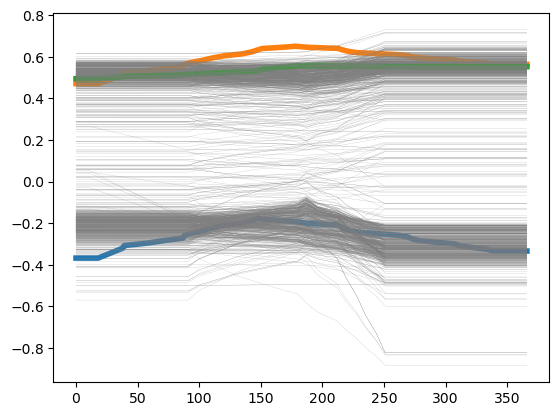

In [36]:
doy_366 = np.linspace(0,366,367)
ndvi_interp_366 = np.empty([ndvi_interp.shape[0],367])
for i in range (len(ndvi_interp)):
    ndvi_interp_366[i] = np.interp(doy_366, x, ndvi_interp[i])
fold = os.path.join(script_path, "pkl")
pikles = []
pkl_names = []
for filename in os.listdir(fold):
    if filename.endswith(".pkl"):
        read_pkl = pd.read_pickle(os.path.join(script_path, "pkl",filename))  
        pikles.append(read_pkl)
        pkl_names.append(filename[:-4])
print(pkl_names)
for p in pikles:
    df = pd.DataFrame(p)
    plt.plot(p+optimal_bias,linewidth = 4)
    for i in range (0,400):
        rand = random.randint(0, 4000)
        plt.plot(ndvi_interp_366[rand], color='grey',linewidth = 0.1)
    unpickled_df = None
print("length of random ndvi_interp",len(ndvi_interp_366[rand]))
print("length of read_pickle",len(p))
lcms = math.lcm(len(ndvi_interp_366[rand]),len(p))
plt.show()

In [ ]:
#define dynamic time warping to measure the similarity between standards and each pixel's ndvi time series
def DTWDistance(s1, s2):
    DTW={}

    for i in range(len(s1)):
        DTW[(i, -1)] = float('inf')
    for i in range(len(s2)):
        DTW[(-1, i)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(len(s2)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return np.sqrt(DTW[len(s1)-1, len(s2)-1])

#calculated the distance by DTW
d1 = np.zeros((clipped_area,len(pikles)))   
ClassNum = np.zeros((clipped_area,1)) 
for pt in range(len(pikles)):
    pt_list = pikles[pt].values.tolist()
    for i in range(0,clipped_area): 
        data_f = pikles[pt]+optimal_bias
        d1[i][pt] = DTWDistance(data_f[0],ndvi_interp[i][:])

#assign the class that has the smallest distance as the dominant class of the pixel
for i in range(0,clipped_area):
     ClassNum[i] = np.argmin(d1[i][:])
C = ClassNum+1

#add all the nan pixels
Class1D = np.empty((pixels_N,1)) 
Class1D[:] = np.nan
len_ndvi = len(ndvi_index) 
for i in range(0,len_ndvi): 
    rowNum = ndvi_index[i]
    Class1D[rowNum,:] = C[i]

#### convert 1D array to 2D
Class2D = np.empty([raster_height,raster_width])
Class2D[:] = np.nan
for i in range (0,pixels_N):
    row = np.floor(i/raster_width).astype(int)
    column = np.remainder(i,raster_width)
    Class2D[row][column] = Class1D[i]

#plot the classificaiton result    
plt.clf()    
from matplotlib import colors    
cmap = colors.ListedColormap(['blue','green','brown'])  
plt.figure()  
plt.imshow(Class2D, cmap)
cbar = plt.colorbar(ticks = [1,2,3])
cbar.set_ticklabels(pkl_names) 
#plt.savefig('class2017') 
plt.show()

In [22]:
#save the classification result to tiff
file = script_path + '/projection_files/LA3-template.tif' #using this image's projection information to save the tiff
ds = gdal.Open(file)
band = ds.GetRasterBand(1)
arr = band.ReadAsArray()
[cols, rows] = arr.shape
driver = gdal.GetDriverByName("GTiff")
outdata = driver.Create("LA3-HLS-L30-class-2017-v5.3_bias0.06316407.tif", rows, cols, 1, gdal.GDT_UInt16)
outdata.SetGeoTransform(ds.GetGeoTransform())##sets same geotransform as input
outdata.SetProjection(ds.GetProjection())##sets same projection as input
outdata.GetRasterBand(1).WriteArray(Class2D)
outdata.GetRasterBand(1).SetNoDataValue(-9999)##if you want these values transparent
outdata.FlushCache() ##saves to disk!!
outdata = None
band=None
ds=None